In [2]:
%matplotlib inline


# Training A2C with Vector Envs and Domain Randomization


## Notice

If you encounter an RuntimeError like the following comment raised on multiprocessing/spawn.py, wrap up the code from ``gym.vector.make=`` or ``gym.vector.AsyncVectorEnv`` to the end of the code by ``if__name__ == '__main__'``.

``An attempt has been made to start a new process before the current process has finished its bootstrapping phase.``




------------------------------




## Introduction

In this tutorial, you'll learn how to use vectorized environments to train an Advantage Actor-Critic agent.
We are going to use A2C, which is the synchronous version of the A3C algorithm [1].

Vectorized environments [3] can help to achieve quicker and more robust training by allowing multiple instances
of the same environment to run in parallel (on multiple CPUs). This can significantly reduce the variance and thus speeds up the training.

We will implement an Advantage Actor-Critic from scratch to look at how you can feed batched states into your networks to get a vector of actions
(one action per environment) and calculate the losses for actor and critic on minibatches of transitions.
Each minibatch contains the transitions of one sampling phase: `n_steps_per_update` steps are executed in `n_envs` environments in parallel
(multiply the two to get the number of transitions in a minibatch). After each sampling phase,  the losses are calculated and one gradient step is executed.
To calculate the advantages, we are going to use the Generalized Advantage Estimation (GAE) method [2], which balances the tradeoff
between variance and bias of the advantage estimates.

The A2C agent class is initialized with the number of features of the input state, the number of actions the agent can take,
the learning rates and the number of environments that run in parallel to collect experiences. The actor and critic networks are defined
and their respective optimizers are initialized. The forward pass of the networks takes in a batched vector of states and returns a tensor of state values
and a tensor of action logits. The select_action method returns a tuple of the chosen actions, the log-probs of those actions, and the state values for each action.
In addition, it also returns the entropy of the policy distribution, which is subtracted from the loss later (with a weighting factor `ent_coef`) to encourage exploration.

The get_losses function calculates the losses for the actor and critic networks (using GAE), which are then updated using the update_parameters function.




------------------------------




In [3]:
# Author: Till Zemann
# License: MIT License

# from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import gymnasium as gym

## Advantage Actor-Critic (A2C)

The Actor-Critic combines elements of value-based and policy-based methods. In A2C, the agent has two separate neural networks:
a critic network that estimates the state-value function, and an actor network that outputs logits for a categorical probability distribution over all actions.
The critic network is trained to minimize the mean squared error between the predicted state values and the actual returns received by the agent
(this is equivalent to minimizing the squared advantages, because the advantage of an action is as the difference between the return and the state-value: A(s,a) = Q(s,a) - V(s).
The actor network is trained to maximize the expected return by selecting actions that have high expected values according to the critic network.

The focus of this tutorial will not be on the details of A2C itself. Instead, the tutorial will focus on how to use vectorized environments
and domain randomization to accelerate the training process for A2C (and other reinforcement learning algorithms).




------------------------------




In [4]:
class A2C(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class

    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """

    def __init__(
        self,
        n_features: int,
        n_actions: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
        n_envs: int,
    ) -> None:
        """Initializes the actor and critic networks and their respective optimizers."""
        super().__init__()
        self.device = device
        self.n_envs = n_envs

        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(
                32, n_actions
            ),  # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.

        Args:
            x: A batched vector of states.

        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.

        Args:
            x: A batched vector of states.

        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
            state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(
            logits=action_logits
        )  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic
        using Generalized Advantage Estimation (GAE) to compute the advantages (https://arxiv.org/abs/1506.02438).

        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).

        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = (
                rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t]
            )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
        )
        return (critic_loss, actor_loss)

    def update_parameters(
        self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
    ) -> None:
        """
        Updates the parameters of the actor and critic networks.

        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

## Using Vectorized Environments

When you calculate the losses for the two Neural Networks over only one epoch, it might have a high variance. With vectorized environments,
we can play with `n_envs` in parallel and thus get up to a linear speedup (meaning that in theory, we collect samples `n_envs` times quicker)
that we can use to calculate the loss for the current policy and critic network. When we are using more samples to calculate the loss,
it will have a lower variance and theirfore leads to quicker learning.

A2C is a synchronous method, meaning that the parameter updates to Networks take place deterministically (after each sampling phase),
but we can still make use of asynchronous vector envs to spawn multiple processes for parallel environment execution.

The simplest way to create vector environments is by calling `gym.vector.make`, which creates multiple instances of the same environment:




In [5]:
envs = gym.vector.make("LunarLander-v2", num_envs=3, max_episode_steps=600)

/home/fccoelho/MEGAsync/Cursos/Reinforcement Learning/Reinforcement-Learning-course/.venv/lib/python3.11/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


## Domain Randomization

If we want to randomize the environment for training to get more robust agents (that can deal with different parameterizations of an environment
and theirfore might have a higher degree of generalization), we can set the desired parameters manually or use a pseudo-random number generator to generate them.

Manually setting up 3 parallel 'LunarLander-v2' envs with different parameters:



In [6]:
envs = gym.vector.AsyncVectorEnv(
    [
        lambda: gym.make(
            "LunarLander-v2",
            gravity=-10.0,
            enable_wind=True,
            wind_power=15.0,
            turbulence_power=1.5,
            max_episode_steps=600,
        ),
        lambda: gym.make(
            "LunarLander-v2",
            gravity=-9.8,
            enable_wind=True,
            wind_power=10.0,
            turbulence_power=1.3,
            max_episode_steps=600,
        ),
        lambda: gym.make(
            "LunarLander-v2", gravity=-7.0, enable_wind=False, max_episode_steps=600
        ),
    ]
)

------------------------------

Randomly generating the parameters for 3 parallel 'LunarLander-v2' envs, using `np.clip` to stay in the recommended parameter space:




In [7]:
envs = gym.vector.AsyncVectorEnv(
    [
        lambda: gym.make(
            "LunarLander-v2",
            gravity=np.clip(
                np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max=-0.01
            ),
            enable_wind=np.random.choice([True, False]),
            wind_power=np.clip(
                np.random.normal(loc=15.0, scale=1.0), a_min=0.01, a_max=19.99
            ),
            turbulence_power=np.clip(
                np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99
            ),
            max_episode_steps=600,
        )
        for i in range(3)
    ]
)

------------------------------

Here we are using normal distributions with the standard parameterization of the environment as the mean and an arbitrary standard deviation (scale).
Depending on the problem, you can experiment with higher variance and use different distributions as well.

If you are training on the same `n_envs` environments for the entire training time, and `n_envs` is a relatively low number
(in proportion to how complex the environment is), you might still get some overfitting to the specific parameterizations that you picked.
To mitigate this, you can either pick a high number of randomly parameterized environments or remake your environments every couple of sampling phases
to generate a new set of pseudo-random parameters.




## Setup




In [8]:
# environment hyperparams
n_envs = 20
n_updates = 1000
n_steps_per_update = 128
randomize_domain = False

# agent hyperparams
gamma = 0.999
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
if randomize_domain:
    envs = gym.vector.AsyncVectorEnv(
        [
            lambda: gym.make(
                "LunarLander-v2",
                gravity=np.clip(
                    np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max=-0.01
                ),
                enable_wind=np.random.choice([True, False]),
                wind_power=np.clip(
                    np.random.normal(loc=15.0, scale=1.0), a_min=0.01, a_max=19.99
                ),
                turbulence_power=np.clip(
                    np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99
                ),
                max_episode_steps=600,
            )
            for i in range(n_envs)
        ]
    )

else:
    envs = gym.vector.make("LunarLander-v2", num_envs=n_envs, max_episode_steps=600)


obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

## Training the A2C Agent

For our training loop, we are using the `RecordEpisodeStatistics` wrapper to record the episode lengths and returns and we are also saving
the losses and entropies to plot them after the agent finished training.

You may notice that the don't reset the vectorized envs at the start of each episode like we would usually do.
This is because each environment resets automatically once the episode finishes (each environment takes a different number of timesteps to finish
an episode because of the random seeds). As a result, we are also not collecting data in `episodes`, but rather just play a certain number of steps
(`n_steps_per_update`) in each environment (as an example, this could mean that we play 20 timesteps to finish an episode and then
use the rest of the timesteps to begin a new one).




In [9]:
# create a wrapper environment to save episode returns and episode lengths
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []

# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    # at the start of training reset all envs to get an initial state
    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(
            states
        )

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(
            actions.cpu().numpy()
        )

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor([not term for term in terminated])

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        lam,
        ent_coef,
        device,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


## Plotting




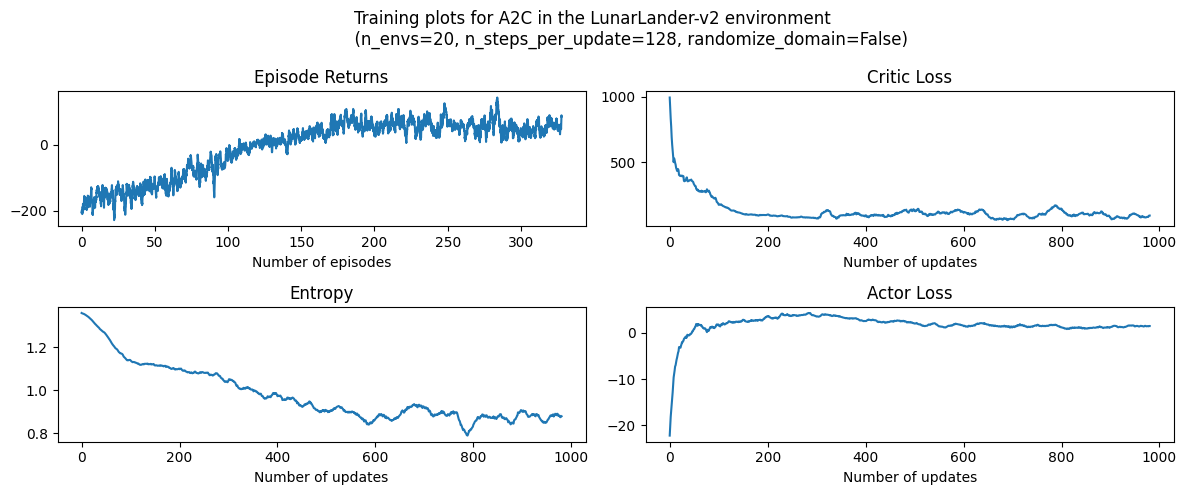

In [10]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the LunarLander-v2 environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

<img src="file://_static/img/tutorials/vector_env_a2c_training_plots.png" alt="training_plots">




## Performance Analysis of Synchronous and Asynchronous Vectorized Environments




------------------------------

Asynchronous environments can lead to quicker training times and a higher speedup
for data collection compared to synchronous environments. This is because asynchronous environments
allow multiple agents to interact with their environments in parallel,
while synchronous environments run multiple environments serially.
This results in better efficiency and faster training times for asynchronous environments.




<img src="file://_static/img/tutorials/vector_env_performance_plots.png" alt="performance_plots">




------------------------------

According to the Karp-Flatt metric (a metric used in parallel computing to estimate the limit for the
speedup when scaling up the number of parallel processes, here the number of environments),
the estimated max. speedup for asynchronous environments is 57, while the estimated maximum speedup
for synchronous environments is 21. This suggests that asynchronous environments have significantly
faster training times compared to synchronous environments (see graphs).




<img src="file://_static/img/tutorials/vector_env_karp_flatt_plot.png" alt="karp_flatt_metric">




------------------------------

However, it is important to note that increasing the number of parallel vector environments
can lead to slower training times after a certain number of environments (see plot below, where the
agent was trained until the mean training returns were above -120). The slower training times might occur
because the gradients of the environments are good enough after a relatively low number of environments
(especially if the environment is not very complex). In this case, increasing the number of environments
does not increase the learning speed, and actually increases the runtime, possibly due to the additional time
needed to calculate the gradients. For LunarLander-v2, the best performing configuration used a AsyncVectorEnv
with 10 parallel environments, but environments with a higher complexity may require more
parallel environments to achieve optimal performance.




<img src="file://_static/img/tutorials/vector_env_runtime_until_threshold.png" alt="runtime_until_threshold_plot">




## Saving/ Loading Weights




In [12]:
save_weights = False
load_weights = False

actor_weights_path = "weights/actor_weights.h5"
critic_weights_path = "weights/critic_weights.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## Showcase the Agent




In [13]:
""" play a couple of showcase episodes """

n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    if randomize_domain:
        env = gym.make(
            "LunarLander-v2",
            render_mode="human",
            gravity=np.clip(
                np.random.normal(loc=-10.0, scale=2.0), a_min=-11.99, a_max=-0.01
            ),
            enable_wind=np.random.choice([True, False]),
            wind_power=np.clip(
                np.random.normal(loc=15.0, scale=2.0), a_min=0.01, a_max=19.99
            ),
            turbulence_power=np.clip(
                np.random.normal(loc=1.5, scale=1.0), a_min=0.01, a_max=1.99
            ),
            max_episode_steps=500,
        )
    else:
        env = gym.make("LunarLander-v2", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :])

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...
starting episode 1...
starting episode 2...


## Try playing the environment yourself




In [ ]:
# from gymnasium.utils.play import play
#
# play(gym.make('LunarLander-v2', render_mode='rgb_array'),
#     keys_to_action={'w': 2, 'a': 1, 'd': 3}, noop=0)

## References

[1] V. Mnih, A. P. Badia, M. Mirza, A. Graves, T. P. Lillicrap, T. Harley, D. Silver, K. Kavukcuoglu. "Asynchronous Methods for Deep Reinforcement Learning" ICML (2016).

[2] J. Schulman, P. Moritz, S. Levine, M. Jordan and P. Abbeel. "High-dimensional continuous control using generalized advantage estimation." ICLR (2016).

[3] Gymnasium Documentation: Vector environments. (URL: https://gymnasium.farama.org/api/vector/)

